<a href="https://colab.research.google.com/github/NehaKumari500092077/Machine-Learning-Lab/blob/main/Session_7_Machine_Learning_Laboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective:**

To gain an understanding of convolutional neural networks using PyTorch.

# **Outline:**

1.   **Data Loading**
* Load the CIFAR-10 dataset.
* Visualize sample images from the dataset.
* Perform one-hot encoding of target labels for multi-class classification.
* Split the dataset into training, validation, and test sets for model evaluation and generalization.
2.   **Data Augmentation**
* Perform data augmentation (flipping, rotation, color jitter)
3. **Data Splitting**
* Split the dataset into training, validation, and test sets for model evaluation and generalization.
4. **Create Dataloaders**
5. **Design a CNN**
* Design an appropriate CNN model having few convolutional layers (4-6), followed by ReLU activation. Insert Max Pooling after every 2 layers.
6. **Loss Function**
* Define the loss function for multi-class classification
7. **Model Training**
* Train the model using SGD with an appropriate minibatch size and learning rate. Record the validation loss obtained after every epoch. Save the trained model.
8. **Loss Plots**
* Plot the training and validation losses.
9. **Model Evaluation**
* Load the trained model and evaluate the model on the test set, and show the classification report as well as the confusion matrix.











In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:08<00:00, 20813814.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA Available: ", cuda_available)

CUDA Available:  True


In [ ]:
print(f"Number of samples in trainset: {len(trainset)}")
print(f"Number of samples in trainset: {len(testset)}")

Number of samples in trainset: 50000
Number of samples in trainset: 10000


In [ ]:
# Access the first sample to check its shape
image, label = trainset[0]
print(f"Shape of the image: {image.shape}")
print(f"Label: {label}")

Shape of the image: torch.Size([3, 32, 32])
Label: 6


In [ ]:
classes = trainset.classes

# Print class names
print("Class labels and their corresponding names:")
for idx, class_name in enumerate(classes):
    print(f"Label {idx}: {class_name}")

Class labels and their corresponding names:
Label 0: airplane
Label 1: automobile
Label 2: bird
Label 3: cat
Label 4: deer
Label 5: dog
Label 6: frog
Label 7: horse
Label 8: ship
Label 9: truck


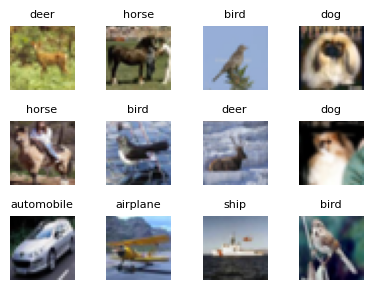

In [ ]:
# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')  # Hide axes

# Function to visualize samples from the dataset
def visualize_samples(dataset, num_samples=12, images_per_row=4):
    # Ensure num_samples is a perfect square for a square grid
    num_rows = num_samples // images_per_row

    # Select a few samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    # Prepare the figure for plotting
    plt.figure(figsize=(images_per_row , num_rows ))  # Adjust figure size

    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        # Create a subplot for each image
        plt.subplot(num_rows, images_per_row, i + 1)
        imshow(img)
        plt.title(classes[label], fontsize=8)  # Adjust font size for readability

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Visualize sample images
visualize_samples(trainset, num_samples=12, images_per_row=4)

In [ ]:
import torch.nn.functional as F
# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

# Create a one-hot encoded version of the dataset
train_labels = torch.tensor([label for _, label in trainset])
train_one_hot_labels = one_hot_encode(train_labels)

In [ ]:
# Display some one-hot encoded labels along with class names
def display_one_hot_labels(one_hot_labels, labels, class_names, num_samples=5):
    for i in range(num_samples):
        one_hot_label = one_hot_labels[i]
        label_int = torch.argmax(one_hot_label).item()  # Get the index of the max value in the one-hot vector
        print(f"One-hot encoded label: {one_hot_label.numpy()}")  # Display one-hot encoded label
        print(f"Original label index: {labels[i].item()}")  # Display the original label index
        print(f"Corresponding class name: {class_names[label_int]}\n")  # Display the class name


# Display some one-hot encoded labels along with their class names
display_one_hot_labels(train_one_hot_labels, train_labels, classes, num_samples=5)

One-hot encoded label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Original label index: 6
Corresponding class name: frog

One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Original label index: 9
Corresponding class name: truck

One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Original label index: 9
Corresponding class name: truck

One-hot encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original label index: 4
Corresponding class name: deer

One-hot encoded label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label index: 1
Corresponding class name: automobile



Files already downloaded and verified
Visualizing Augmented Images:


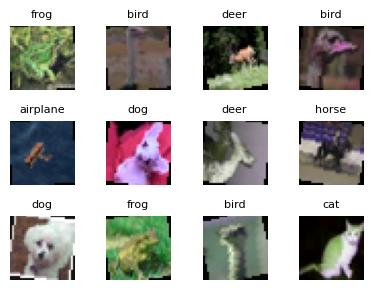

In [ ]:
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),      # Randomly rotate images by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmented_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=augmented_transform)

# # Visualize sample images from the original dataset
# print("Visualizing Original Images:")
# visualize_samples(trainset, num_samples=12, images_per_row=4)

# Visualize sample images from the augmented dataset
print("Visualizing Augmented Images:")
visualize_samples(augmented_trainset, num_samples=12, images_per_row=4)


In [ ]:
# Split dataset into training, validation and test sets

from torch.utils.data import random_split
# Split the train_dataset into training and validation sets
train_size = int(0.8 * len(augmented_trainset))  # 80% for training
val_size = len(augmented_trainset) - train_size
trainset, valset = random_split(augmented_trainset, [train_size, val_size])

print("Dataset sizes:")
print(f"Training set: {len(trainset)}")
print(f"Validation set: {len(valset)}")
print(f"Test set: {len(testset)}")

Dataset sizes:
Training set: 40000
Validation set: 10000
Test set: 10000


In [ ]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(valset, batch_size=64, shuffle=False)
test_loader = DataLoader(testset, batch_size=1000, shuffle=False)

# Check if DataLoaders are working
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(len(train_loader), len(val_loader))

625 157


In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 8 * 8, 64)  # Adjust input features based on image size
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)  # Output layer for 10 classes (CIFAR-10)

    def forward(self, x):
        # Convolutional layers with ReLU activation

        x = F.relu(self.conv1(x))

        # Input Image Size: 32x32 with 3 channels.
        # After Conv1 (32 filters, 3x3 kernel, padding=1, stride=1):
        # Output Size: 32x32 (same as input due to padding)

        x = F.relu(self.conv2(x))

        # After Conv2 (64 filters, 3x3 kernel, padding=1, stride=1):
        # Output Size: 32x32 (same as input due to padding)

        x = self.maxpool(x)

        # After MaxPool (2x2 kernel, stride=2)
        # Output Size: 16x16 (halved due to pooling)

        x = F.relu(self.conv3(x))

        # After Conv3 (128 filters, 3x3 kernel, padding=1, stride=1)
        # Output Size: 16x16 (same as input due to padding)

        x = F.relu(self.conv4(x))

        # After Conv4 (256 filters, 3x3 kernel, padding=1, stride=1)
        # Output Size: 16x16 (same as input due to padding)

        x = self.maxpool(x)
        # print(x.shape)

        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)

        # Flattening
        # Number of Features: 1024 channels * 4 height * 4 width = 16384

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
# Instantiate the model
model = SimpleCNN()
print(model)
if cuda_available:
  model.cuda()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
# Define the loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (SGD)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Training parameters
num_epochs = 50

# Lists to store training and validation losses
train_losses = []
val_losses = []

# # Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training
    for images, labels in train_loader:
        optimizer.zero_grad()
        if cuda_available:
          images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # running_loss += loss.item() * images.size(0)

    avg_train_loss = running_loss / len(train_loader) # avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
          if cuda_available:
            images, labels = images.cuda(), labels.cuda()
          outputs = model(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item() # val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader) # epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch [1/50], Training Loss: 2.3036, Validation Loss: 2.2990
Epoch [2/50], Training Loss: 2.2859, Validation Loss: 2.2358
Epoch [3/50], Training Loss: 2.1908, Validation Loss: 2.0865
Epoch [4/50], Training Loss: 2.0933, Validation Loss: 2.0121
Epoch [5/50], Training Loss: 2.0481, Validation Loss: 1.9588
Epoch [6/50], Training Loss: 2.0040, Validation Loss: 1.9121
Epoch [7/50], Training Loss: 1.9454, Validation Loss: 1.8415
Epoch [8/50], Training Loss: 1.8829, Validation Loss: 1.7509
Epoch [9/50], Training Loss: 1.8245, Validation Loss: 1.6884
Epoch [10/50], Training Loss: 1.7771, Validation Loss: 1.6410
Epoch [11/50], Training Loss: 1.7328, Validation Loss: 1.5935
Epoch [12/50], Training Loss: 1.6889, Validation Loss: 1.5934
Epoch [13/50], Training Loss: 1.6572, Validation Loss: 1.5010
Epoch [14/50], Training Loss: 1.6243, Validation Loss: 1.4994
Epoch [15/50], Training Loss: 1.5953, Validation Loss: 1.4397
Epoch [16/50], Training Loss: 1.5679, Validation Loss: 1.4052
Epoch [17/50], Tr

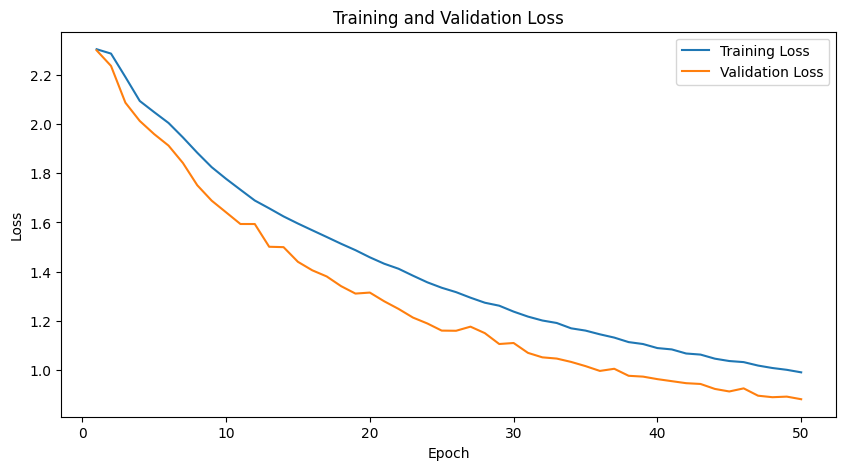

In [ ]:
if cuda_available:
 model = model.to('cpu')

# Save the trained model
torch.save(model.state_dict(), 'simple_cnn.pth')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:

# Load the trained model
model = SimpleCNN()
model.load_state_dict(torch.load('simple_cnn.pth'))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

/tmp/ipykernel_35/3982425426.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('simple_cnn.pth'))


Classification Report:

              precision    recall  f1-score   support

    airplane       0.76      0.81      0.78      1000
  automobile       0.88      0.86      0.87      1000
        bird       0.71      0.46      0.56      1000
         cat       0.50      0.56      0.53      1000
        deer       0.60      0.76      0.67      1000
         dog       0.67      0.58      0.62      1000
        frog       0.78      0.83      0.81      1000
       horse       0.81      0.79      0.80      1000
        ship       0.88      0.83      0.86      1000
       truck       0.79      0.86      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



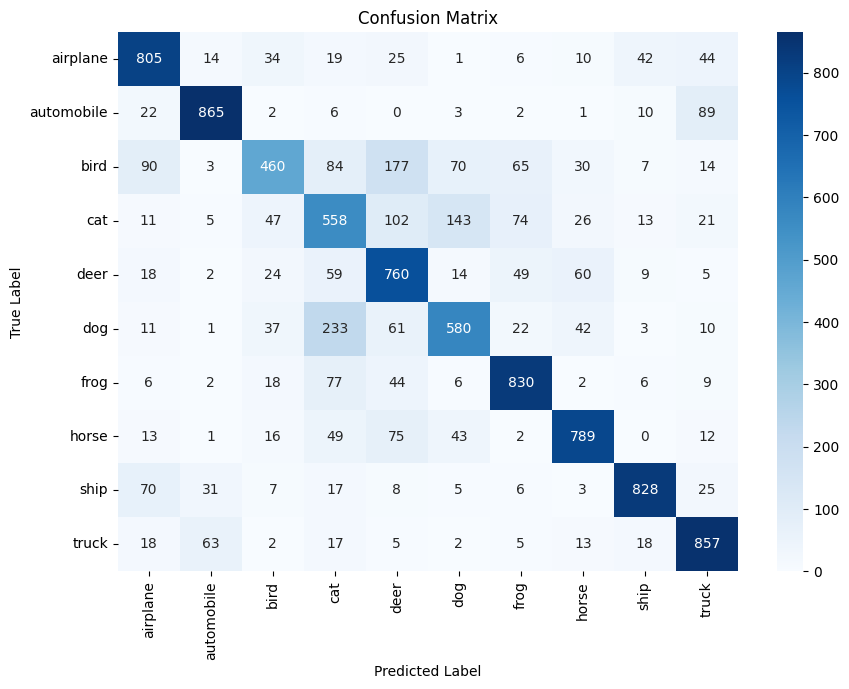

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Generate the classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#  **Assignment 7**

# 1. **Load and Prepare the Oxford-IIIT Pets Dataset [5 Marks]**
* Loading the Dataset
> Load the dataset from torchvision.datasets.OxfordIIITPet. Note that there are two partitions available, and you should use 'trainval' for training and validation, and 'test' for testing.
*  Report Number of Classes
> Count Classes: Determine the number of unique pet breeds (classes) in the dataset.
* Visualize the Dataset
> Random Sample: Display one randomly picked image from each class to visualize the dataset.
* One-Hot Encoding of Labels
> Transform Labels: Convert class labels into one-hot encoded format.
* Resize Images
> Apply Resize: Use torchvision.transforms.Resize to resize all images to 128x128 pixels with bicubic interpolation.
* Class Distribution
> Plot Bar Graph: Plot a bar graph showing the distribution of classes to determine if the dataset is balanced or imbalanced.
# 2. **Data Splitting [1 Marks]**
* Split Dataset
> Divide the 'trainval' partition of the dataset into training (80%), validation (20%). Use the 'test' partition for testing your model.
> Ensure Balanced Splits: Ensure that each partition maintains similar class distributions.
# 3. **Design a CNN Model [7 Marks]**
* Model Architecture
> Define Layers: Design a CNN with a suitable number of convolutional layers, MaxPooling layers, and fully connected layers.
> Adjust Filters: Choose appropriate numbers of filters and kernel sizes for each convolutional layer.
# 4. **Training the Model [5 Marks]**
* Loss Function
> Use an appropriate loss function for this classification task.
* Training Setup
> Optimizer: Use SGD with an appropriate learning rate and momentum.
> Learning Rate Scheduling: Apply torch.optim.lr_scheduler.ReduceLROnPlateau for learning rate scheduling.
> Batch Size: Choose a suitable batch size for training.
* Monitor Losses: Track training and validation losses during training.
# 5. **Evaluate the Model [2 Marks]**
* Test Set Performance
> Model Evaluation: Evaluate the trained model on the test set.
> Confusion Matrix: Generate and display the confusion matrix for the test set.

